In [447]:
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import venn
import warnings
from matplotlib.backends.backend_pdf import PdfPages
warnings.filterwarnings("ignore")

### Read ncRNA db 

In [448]:
# open other ncRNA db file
with open("/Users/hgibriel/Dropbox/sncRNAP/DBs/mouse_sncRNA.fa", "r") as file1:
    content1 = file1.read()

# open concatenated file and count ncRNA classes
lines = content1.splitlines()


### A) ncRNA length

In [449]:
# iterate over ids and extract ncRNA classes
lengths = {}
ncRNA_id = None
for line in lines:
    if 'Mt' in line:
        continue

    if line.startswith(">"):
        if 'trna' in line:
            ncRNA_id = line.split('>')[1].strip() + '_tRNA'
        if 'MIMA' in line:
            ncRNA_id = line.split('>')[1].strip()
            ncRNA_id = line.split('_')[1].strip() + '_miRNA'
        if ('trna' not in line) and ('MIMAT' not in line):
            ncRNA_id = line.split('>')[1].strip()
        lengths[ncRNA_id] = 0
        
    if ('trna' not in line) and ('MIMAT' not in line) and ('ENSMUSG' not in line) and (ncRNA_id is not None):
        lengths[ncRNA_id] += len(line.strip())
                
    if ('trna' not in line) and ('MIMAT' not in line) and ('ENSMUSG' not in line):
        ncRNA_id = None

length_df = pd.DataFrame(list(lengths.items()), columns=['ncRNA_id', 'Length'])
length_df = length_df.dropna()
length_df.loc[length_df['ncRNA_id'].str.contains('tRNA'), 'Length'] = length_df.loc[length_df['ncRNA_id'].str.contains('tRNA'), 'Length'] - 100


Text(250.0, 0.5, 'ncRNA class')

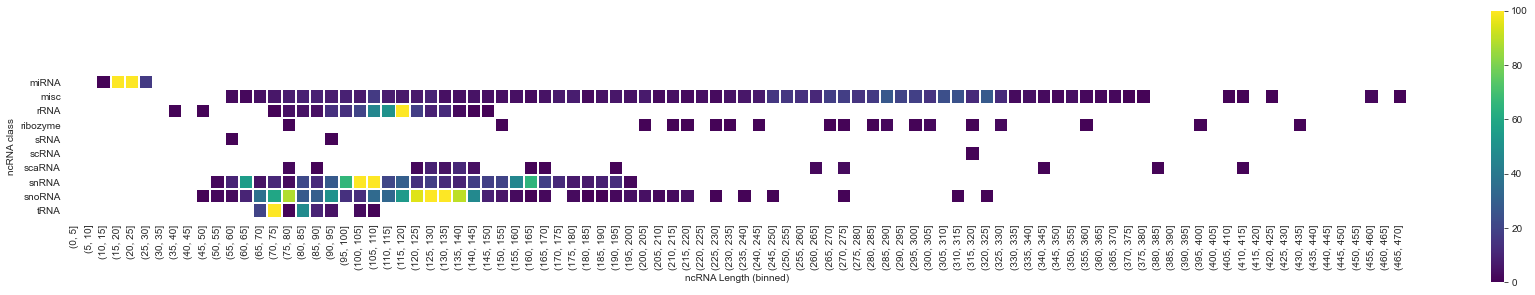

In [450]:
# create an empty list to store the results
data = []

# loop through each row in the length_df
for i, row in length_df.iterrows():
    # split the ncRNA_id column to extract the class
    ncRNA_class = row['ncRNA_id'].split('_')[1]
    length = row['Length']
    
    # add the ncRNA class and length to the data list
    data.append((ncRNA_class, length))

# create a new DataFrame from the data list
data_new = pd.DataFrame(data, columns=['ncRNA_class', 'Length'])
data_new
# remove length values > 500
data_new = data_new[data_new['Length'] <= 500]

# create a range of values to use for the bins
bins = range(0, int(data_new['Length'].max())+5, 5)

# bin the length values
data_new['binned'] = pd.cut(data_new['Length'], bins=bins)

# group the data by ncRNA class and binned length values
grouped = data_new.groupby(['ncRNA_class', 'binned']).count().reset_index()

# create a pivot table from the grouped data
pivot_table = grouped.pivot(index='ncRNA_class', columns='binned', values='Length')

# plot the heatmap and append the figure object to the list
fig1 = plt.figure(figsize=(30,5))
sns.heatmap(pivot_table, cmap='viridis',vmin=0, vmax=100, linewidth =1, square =True)
plt.xlabel('ncRNA Length (binned)')
plt.ylabel('ncRNA class')


### B) ncRNA count

In [451]:
# create a dictionary to store the counts ncRNA lasses
counts = {}

for line in lines:
    # ignore Mt_RNA
    if 'Mt' in line:
        continue
    
    # extract ncRNA class and ignore transcript ids
    if line.startswith(">"):
        if 'trna' in line:
            ncRNA_class = 'tRNA'
            counts[ncRNA_class] = counts.get(ncRNA_class, 0) + 1
            
        if 'MIMA' in line:
            ncRNA_class = 'miRNA'
            counts[ncRNA_class] = counts.get(ncRNA_class, 0) + 1
                   
        if ('trna' not in line) and ('MIMAT' not in line):
            ncRNA_class = line.split('>')[1].strip()
            ncRNA_class = line.split('_')[1].strip()
            counts[ncRNA_class] = counts.get(ncRNA_class, 0) + 1

# create a dataframe to store the result
result_df = pd.DataFrame(list(counts.items()), columns=['ncRNA_class', 'Count'])

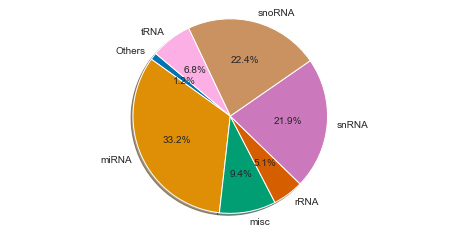

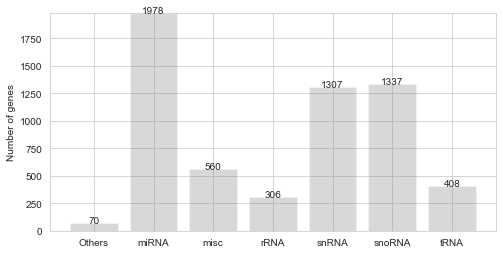

In [452]:
# plot gene count

# calculate the percentage of each class
result_df['Percentage'] = result_df['Count'] / result_df['Count'].sum() * 100

# Combine all classes with a percentage less than 5% into 'Others'
result_df.loc[result_df['Percentage'] < 5, 'ncRNA_class'] = 'Others'

# group the dataframe by the 'ncRNA_class' column
grouped_df = result_df.groupby('ncRNA_class').sum()

# plot the pie chart and append the figure object to the list
fig2, ax = plt.subplots(figsize=(8, 4))
ax.pie(grouped_df['Percentage'], labels=grouped_df.index, autopct='%1.1f%%',
       shadow=True, startangle=140)
ax.axis('equal')

# plot the bar chart and append the figure object to the list
fig3, ax2 = plt.subplots(figsize=(8, 4)) 
bar_counts = grouped_df['Count']
ax2.bar(grouped_df.index, grouped_df['Count'], alpha=0.3, color='gray')
ax2.set_ylim(0, grouped_df['Count'].max())
ax2.set_ylabel('Number of genes')
ax2.set_ylim(0, grouped_df['Count'].max())
for i, v in enumerate(bar_counts):
    ax2.text(i, v + 0.5, str(v), ha='center')


### C) ncRNA counts per sample

In [453]:
# Read CSV file
df = pd.read_csv("/Users/hgibriel/Dropbox/C_vs_T.csv")
df = df.drop(df.columns[0], axis=1)

# rename column id
df = df.rename(columns={df.columns[0]: 'id'})


#### change id names to id_class

In [454]:
# Iterate over the ids 
for i, row in enumerate(df['id']):
    
    if "trna" in row:    
        # change row name to row name + ncRNA_class
        ncRNA_class = 'tRNA'

        new_id = row + "_" + ncRNA_class
        df['id'] = df['id'].replace({row: new_id})
        
    if "MIMA" in row:
        ncRNA_class = 'miRNA'
        new_string = row.split('_')[1]
        new_id = new_string + "_" + ncRNA_class
        df['id'] = df['id'].replace({row: new_id})
    
    if ('trna' not in row) and ('MIMAT' not in row):
        new_id = row
        df['id'] = df['id'].replace({row: new_id})
        
# remove rows that don't have a classification
df = df[~df['id'].str.contains('Mt')]

#### check ncRNA counts across samples

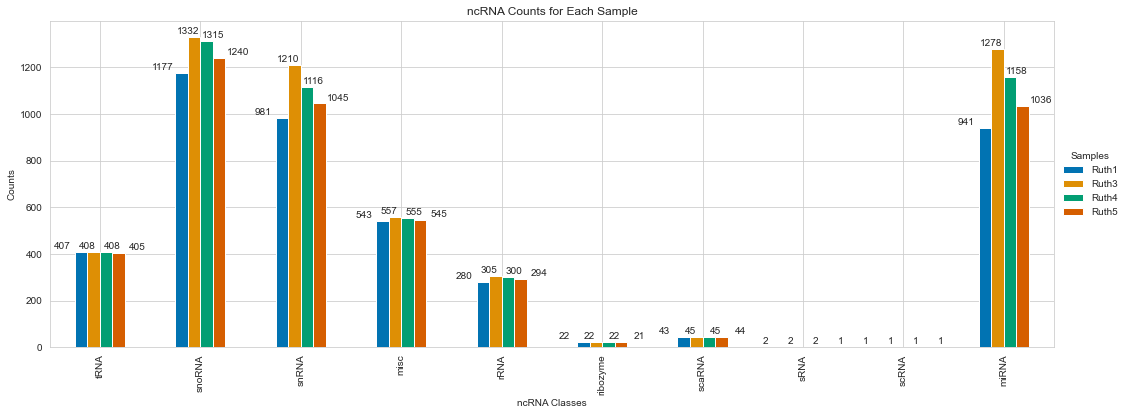

In [455]:
# iterate over column samples and find ids that with values !=0 
counts = {}
for column_name, column_values in df.iloc[:, 4:].iteritems():
    sample_name = column_name
    sample_counts = {}
    for index, value in enumerate(column_values.values):
        if value == 0:
            continue
        row = df.iloc[index, 0]
        
        split_line = row.split('_')
        ncRNA_class = split_line[1].strip()
        sample_counts[ncRNA_class] = sample_counts.get(ncRNA_class, 0) + 1

        counts[sample_name] = sample_counts
    
# create a dataframe to store the result
genes_classes_df = pd.DataFrame(counts)

# barplot
sns.set_style("whitegrid")
sns.set_palette("colorblind")

fig4, ax = plt.subplots(figsize=(18, 6))

genes_classes_df.plot(kind='bar', stacked=False, ax=ax)

for i in range(genes_classes_df.shape[0]):
    for j in range(genes_classes_df.shape[1]):
        count = genes_classes_df.iloc[i, j]
        x_pos = i - 0.5 * (len(genes_classes_df.columns) - 1) / len(genes_classes_df.columns) + j / len(genes_classes_df.columns)
        y_pos = count + 5
        ax.text(x_pos, y_pos, str(count), ha='center', va='bottom')

ax.set_xlabel("ncRNA Classes")
ax.set_ylabel("Counts")
ax.set_title("ncRNA Counts for Each Sample")

ax.legend(title='Samples', frameon=False, loc='center left', bbox_to_anchor=(1.0, 0.5))


#### venn diagram per ncRNA 

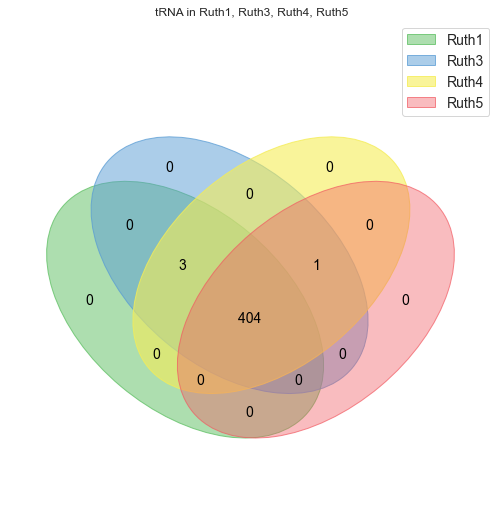

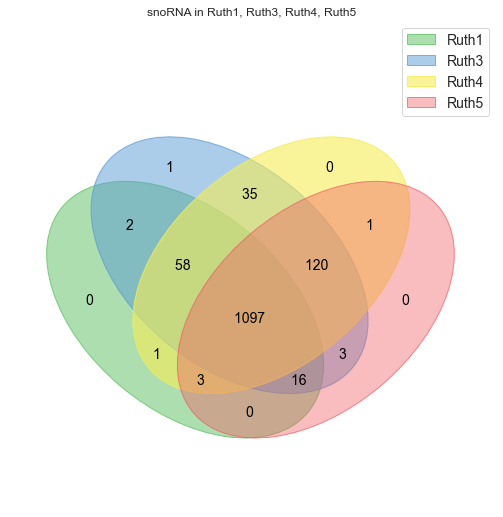

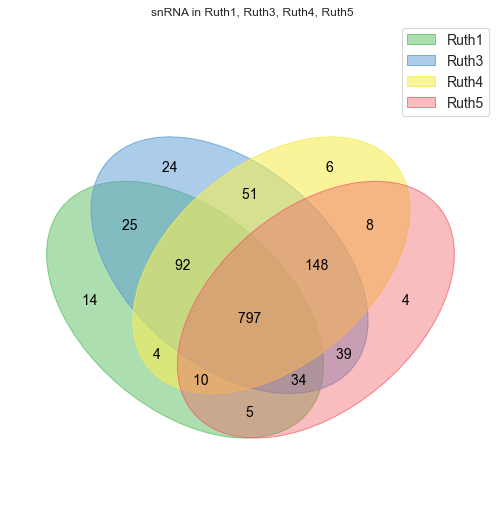

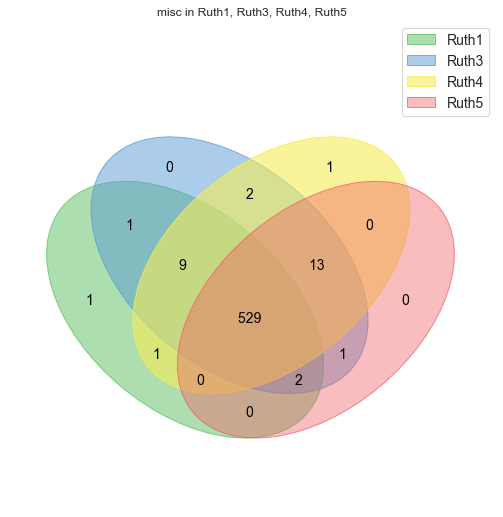

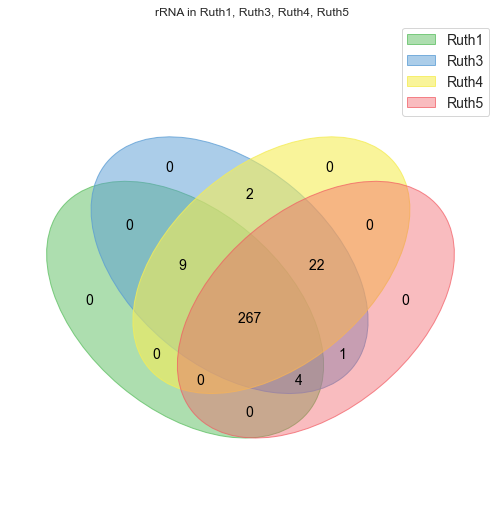

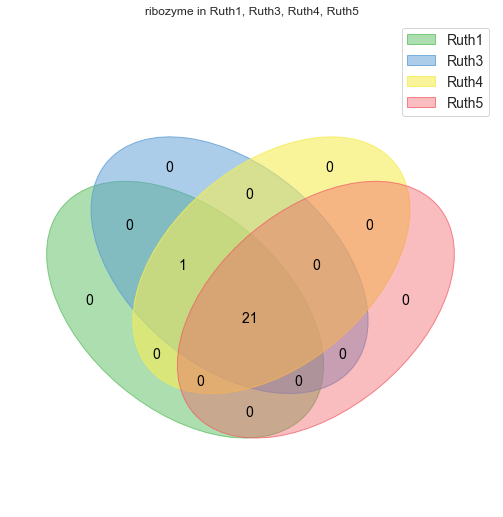

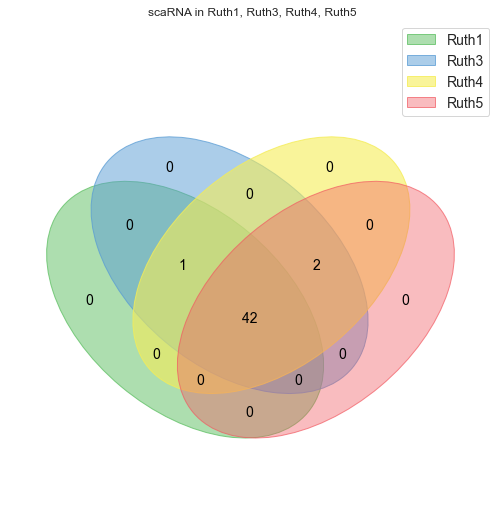

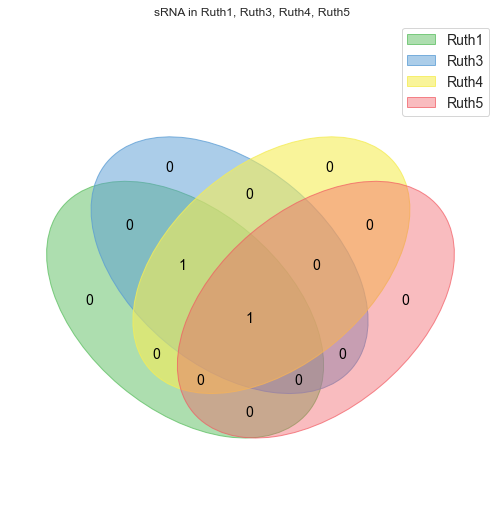

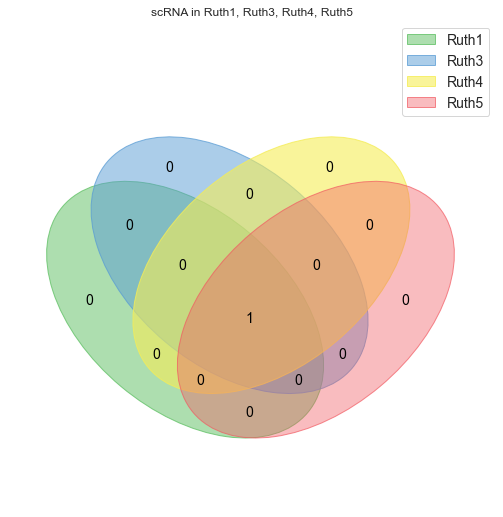

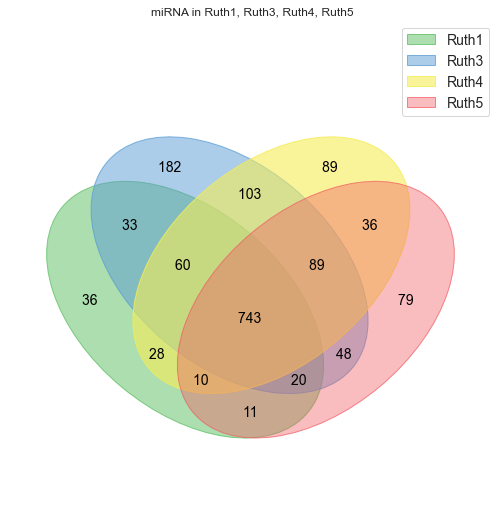

In [456]:
# create a venn df and convert values to 0/1
venn_df = df.drop(df.columns[1:4], axis=1)

# convert values 
threshold = 0
venn_df.iloc[:, 1:] = venn_df.iloc[:, 1:].astype(float)
venn_df.iloc[:, 1:] = venn_df.iloc[:, 1:].applymap(lambda x: np.where(x > threshold, 1, 0))

# venn plot

# Extract sncRNA class from "id" column
venn_df["sncRNA_class"] = venn_df["id"].apply(lambda x: x.split("_")[1])

# Get unique classes
classes = venn_df["sncRNA_class"].unique()

# Get unique sample names
sample_names = [col for col in venn_df.columns if col not in ["id", "sncRNA_class"]]
sample_counts = len(sample_names)

# iterate through each class and plot Venn diagrams for each class
venn_figs = [] # define a list to store all venn diagrams
for class1 in classes:
    class1_data = venn_df[venn_df["sncRNA_class"] == class1].iloc[:, 1:]
    sets = []
    for sample in sample_names:
        sets.append(set(class1_data.index[class1_data[sample] > 0]))
    
    venn_function = getattr(venn, f'venn{sample_counts}')
    labels = venn.get_labels(sets, fill=['number'])
    fig5, ax = venn_function(labels, names=sample_names)
    ax.set_title(f"{class1} in {', '.join(sample_names)}")
    
    venn_figs.append(fig5)


#### expression profile per sample

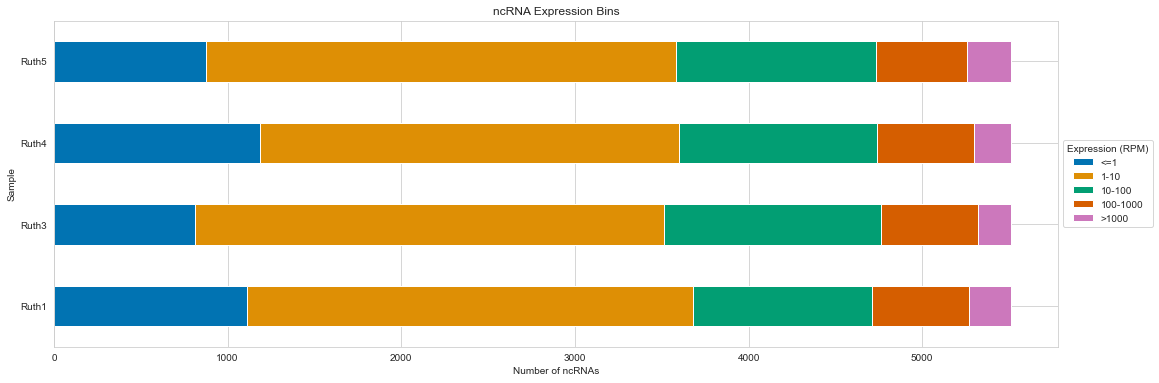

In [457]:
# Create bins for expression values
bins = [0, 1, 10, 100, 1000, float("inf")]
labels = ["<=1", "1-10", "10-100", "100-1000", ">1000"]

# Create a list to store the binned values for each sample
binned_values = []
for column_name, column_values in df.iloc[:, 4:].iteritems():
    sample_name = column_name
    
    # Bin the expression values
    binned_expression_values = pd.cut(column_values, bins=bins, labels=labels, right=False, include_lowest=True)
    
    # Store the binned expression values for each sample
    binned_values.append(pd.DataFrame({'Expression Level': binned_expression_values, 'Sample': sample_name}))

# Concatenate the binned values for each sample
binned_df = pd.concat(binned_values)

# Pivot the data so that each expression level is a column and each sample is a row
binned_df = binned_df.pivot_table(index='Sample', columns='Expression Level', aggfunc='size').fillna(0)

# Plot the binned values as a stacked bar plot
# fig6, ax = plt.subplots()
fig6, ax = plt.subplots(figsize=(18, 6))

binned_df.plot(kind='barh', stacked= True, ax=ax)
ax.set_xlabel("Number of ncRNAs")
ax.set_ylabel("Sample")
ax.set_title("ncRNA Expression Bins")
ax.legend(title="Expression (RPM)",loc="center left", bbox_to_anchor=(1.0, 0.5))
# plt.show()



#### expression profile per ncRNA class

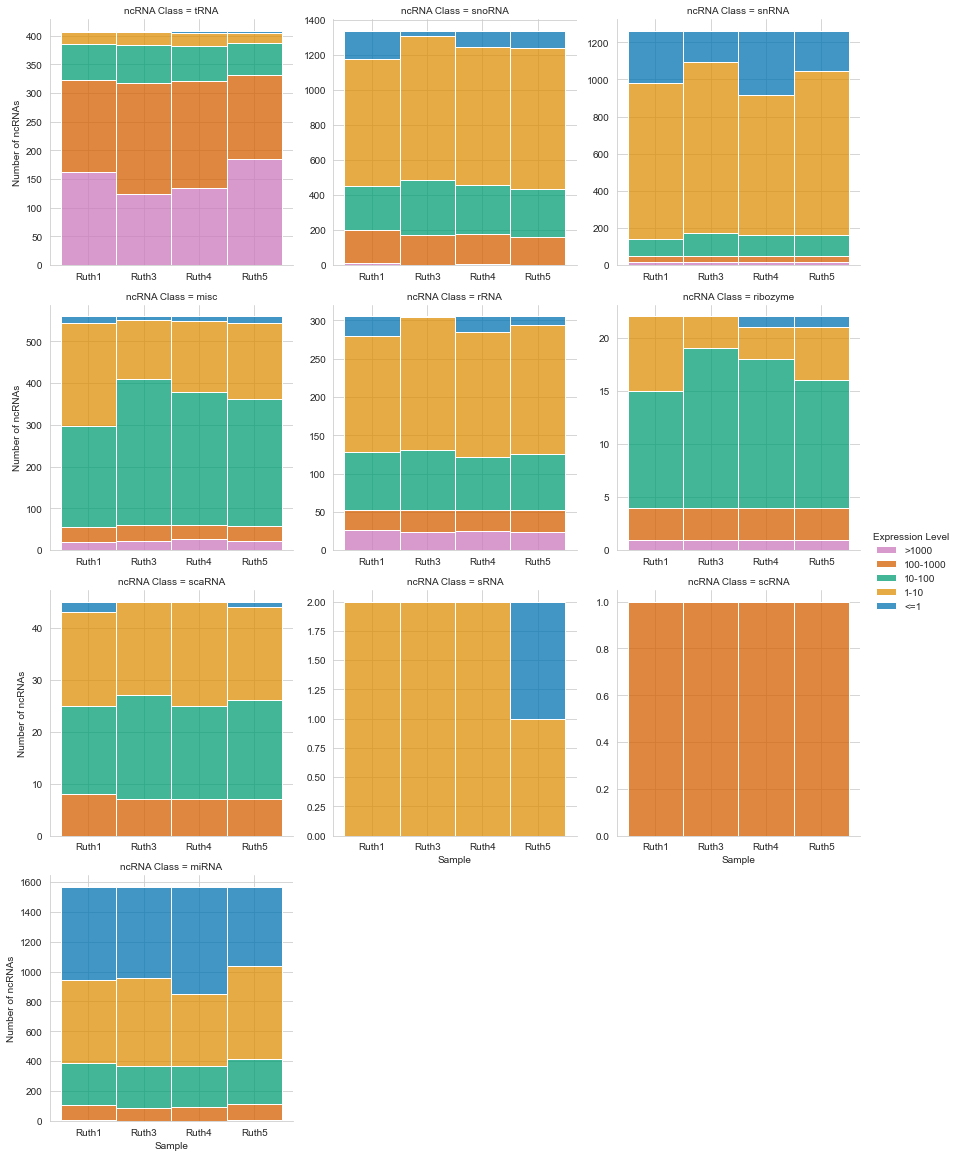

In [458]:
# Create bins for expression values
bins = [0, 1, 10, 100, 1000, float("inf")]
labels = ["<=1", "1-10", "10-100", "100-1000", ">1000"]

# Create a list to store the binned values for each sample and ncRNA class
binned_values = []
for column_name, column_values in df.iloc[:, 4:].iteritems():
    sample_name = column_name
    
    # Bin the expression values
    binned_expression_values = pd.cut(column_values, bins=bins, labels=labels, right=False, include_lowest=True)
    
    # Store the binned expression values for each sample and ncRNA class
    sample_df = pd.DataFrame({'Expression Level': binned_expression_values, 'Sample': sample_name})
    sample_df['ncRNA Class'] = df['id'].apply(lambda x: x.split('_')[1])
    binned_values.append(sample_df)

# Concatenate the binned values for each sample and ncRNA class
binned_df = pd.concat(binned_values)

# Plot each ncRNA class in a separate facet plot
g = sns.FacetGrid(binned_df, col='ncRNA Class', col_wrap=3, height=4, sharex=False, sharey=False)
g.map_dataframe(sns.histplot, x='Sample', hue='Expression Level', multiple='stack')
g.set_axis_labels('Sample', 'Number of ncRNAs')
g.add_legend(title='Expression Level', bbox_to_anchor=(1, 0.5), loc='right', borderaxespad=0., ncol=1, title_fontsize=14, labels=labels[::-1])
fig7 = g.fig



### D) DE ncRNAs

In [459]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5508 entries, 0 to 5531
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              5508 non-null   object 
 1   log2FoldChange  5508 non-null   float64
 2   pvalue          5508 non-null   float64
 3   padj            789 non-null    float64
 4   Ruth1           5508 non-null   float64
 5   Ruth3           5508 non-null   float64
 6   Ruth4           5508 non-null   float64
 7   Ruth5           5508 non-null   float64
dtypes: float64(7), object(1)
memory usage: 387.3+ KB


#### DE gene counts

Text(0.5, 1.0, '7 DE genes')

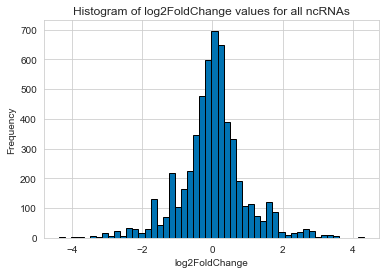

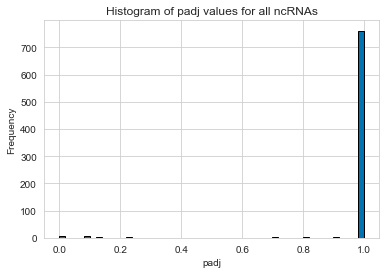

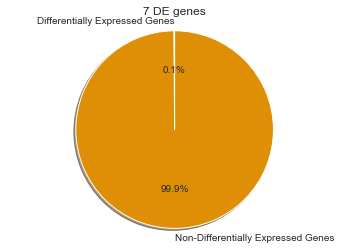

In [460]:
# plot log2fc distribution
fig8 = plt.figure()
plt.hist(df['log2FoldChange'], bins=50, edgecolor='black')
plt.xlabel('log2FoldChange')
plt.ylabel('Frequency')
plt.title('Histogram of log2FoldChange values for all ncRNAs')

# plot padj distribution
fig9 = plt.figure()
plt.hist(df['padj'], bins=50, edgecolor='black')
plt.xlabel('padj')
plt.ylabel('Frequency')
plt.title('Histogram of padj values for all ncRNAs')

# determine DE value threshold nad plot percentage 
counts = ((df['log2FoldChange'] > 1) | (df['log2FoldChange'] < -1)) & (df['padj'] < 0.05)
count = counts.sum()

# Plot the pie chart
fig10 = plt.figure()
labels = ['Differentially Expressed Genes', 'Non-Differentially Expressed Genes']
sizes = [count, len(df)]
ax1 = fig10.add_subplot(111)
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
ax1.set_title(str(count)+' DE genes')


#### DE gene counts per class

Text(0.5, 1.0, 'Number of DE genes')

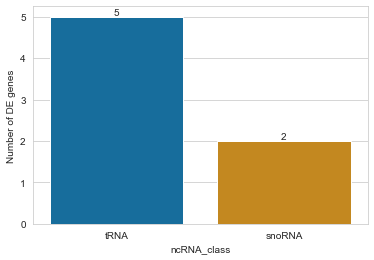

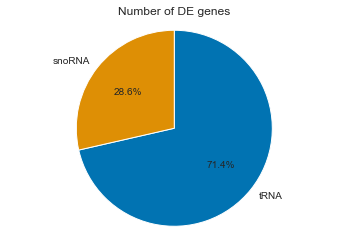

In [461]:
# count DE ncRNAs
differentially_expressed = df[((df['log2FoldChange'] < -1) | (df['log2FoldChange'] > 1)) & (df['padj'] < 0.05)]

# create a dictionary to store the counts ncRNA lasses
counts = {}

# iterate over the rows in the df2 gene id
for row in differentially_expressed[differentially_expressed.columns[0]]:
    split_line = row.split('_')
    ncRNA_class = split_line[1].strip()
    counts[ncRNA_class] = counts.get(ncRNA_class, 0) + 1

# create a dataframe to store the result
DE_classes_df = pd.DataFrame(list(counts.items()), columns=['ncRNA_class', 'Count'])

# Get the count data
counts = DE_classes_df['Count'].tolist()
labels = DE_classes_df['ncRNA_class'].tolist()

# Plot the bar plot using seaborn
fig11 = plt.figure()
sns.barplot(x='ncRNA_class', y='Count', data=DE_classes_df)

# Add the count on top of each bar
for i in range(len(DE_classes_df)):
    count = DE_classes_df['Count'].iloc[i]
    plt.text(i, count, count, ha='center', va='bottom')

plt.ylabel("Number of DE genes")
# plt.show()


# Plot the pie chart
fig12 = plt.figure()
plt.pie(counts, labels=labels, startangle=90, counterclock=False, autopct='%1.1f%%')
plt.axis('equal')
plt.title("Number of DE genes")
# plt.show()


####  padj, log2fc, and DE gene % for each class

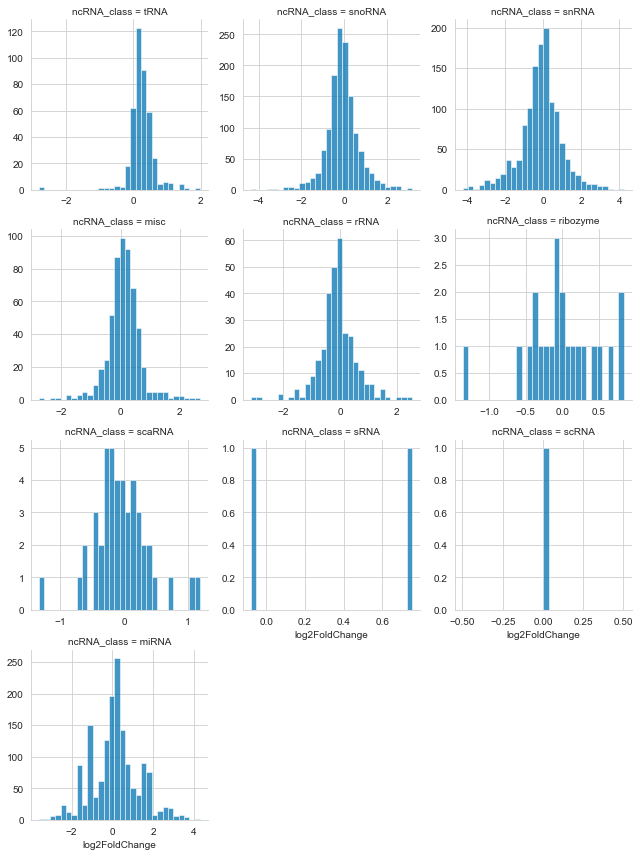

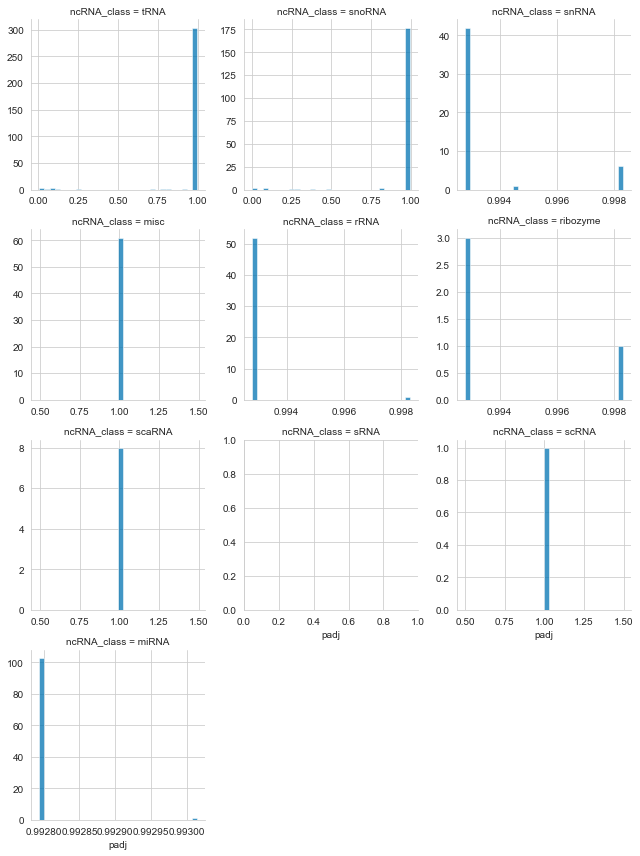

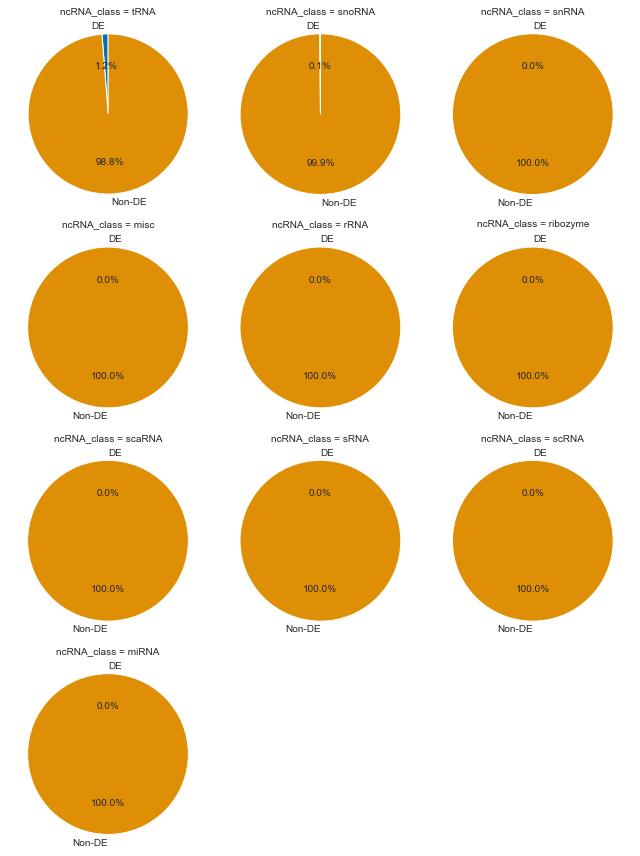

In [462]:
# Split the id column to extract ncRNA class
df['ncRNA_class'] = df['id'].apply(lambda x: x.split("_")[1])

# Define a function to plot the histogram of log2FoldChange and pvalue for each ncRNA class
def plot_histogram(feature, grid):
    grid.map(sns.histplot, feature, bins=30)

# Define a function to plot a pie chart for each ncRNA class
def plot_piechart(data, **kwargs):
    counts = ((data['log2FoldChange'] > 1) | (data['log2FoldChange'] < -1)) & (data['padj'] < 0.05)
    count = counts.sum()
    labels = ['DE', 'Non-DE']
    sizes = [count, len(data) - count]
        
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
    plt.axis('equal')

# Plot histograms for log2fc and pvalues
g1 = sns.FacetGrid(df, col='ncRNA_class', col_wrap=3, sharex=False, sharey=False)
fig13 = g1.fig
plot_histogram('log2FoldChange', g1)

g2 = sns.FacetGrid(df, col='ncRNA_class', col_wrap=3, sharex=False, sharey=False)
fig14 = g2.fig
plot_histogram('padj', g2)

# Plot a pie chart for each ncRNA class
g3 = sns.FacetGrid(df, col='ncRNA_class', col_wrap=3, sharex=False, sharey=False, height=3)
g3.map_dataframe(plot_piechart)
fig15 = g3.fig


#### volcano plot per class

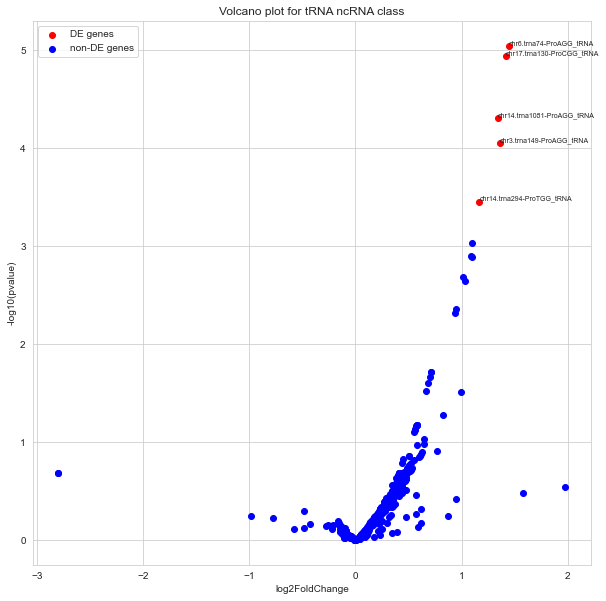

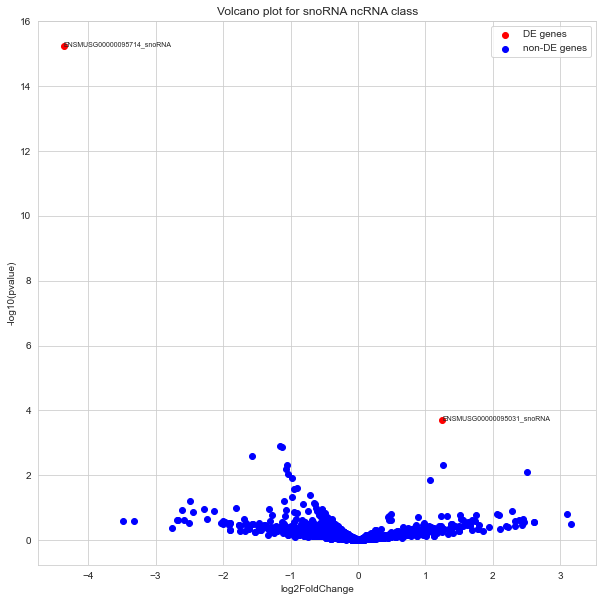

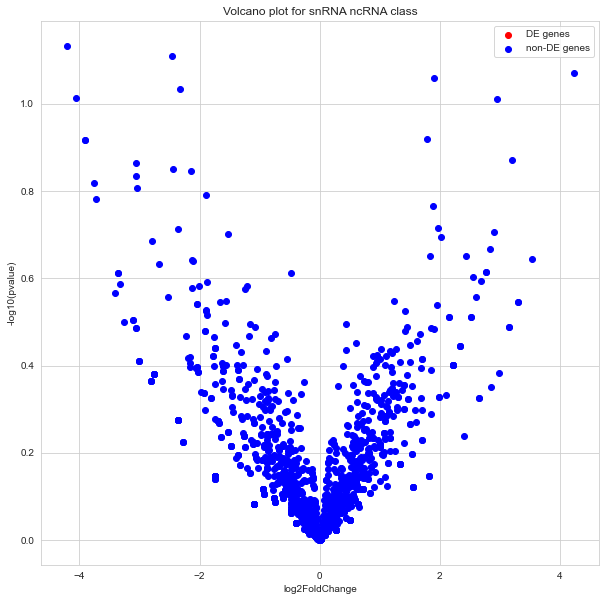

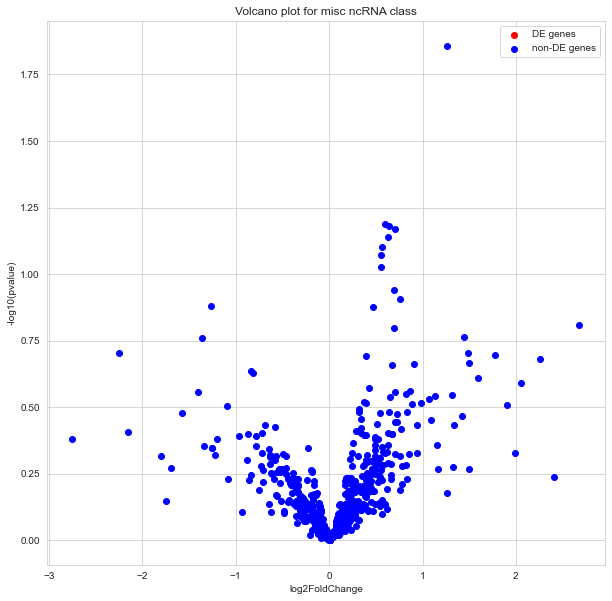

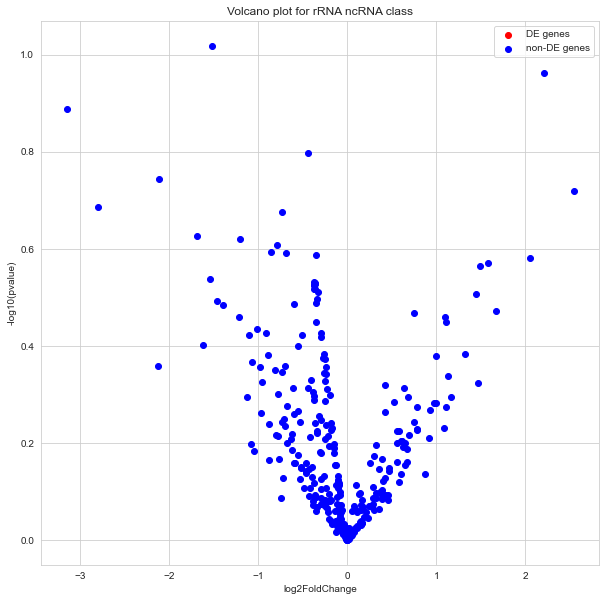

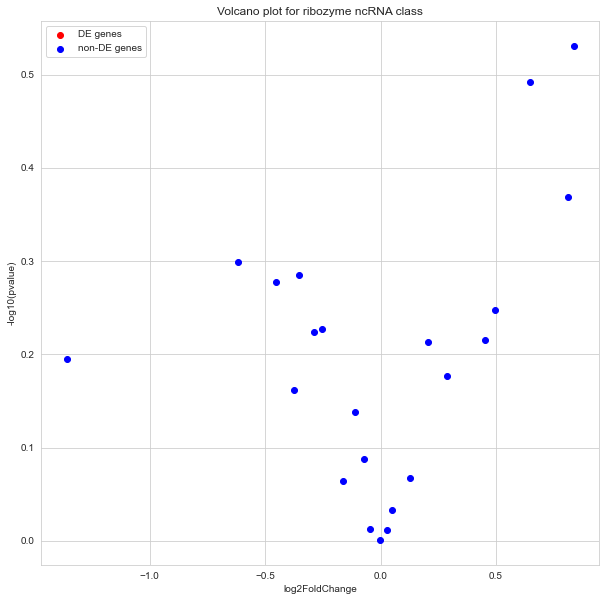

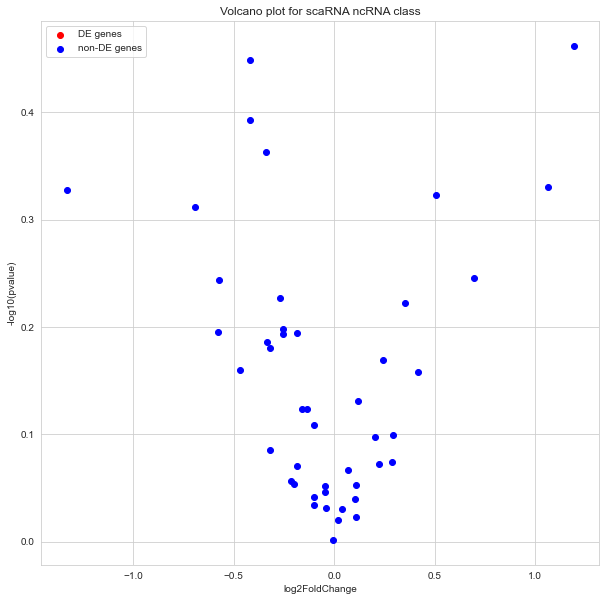

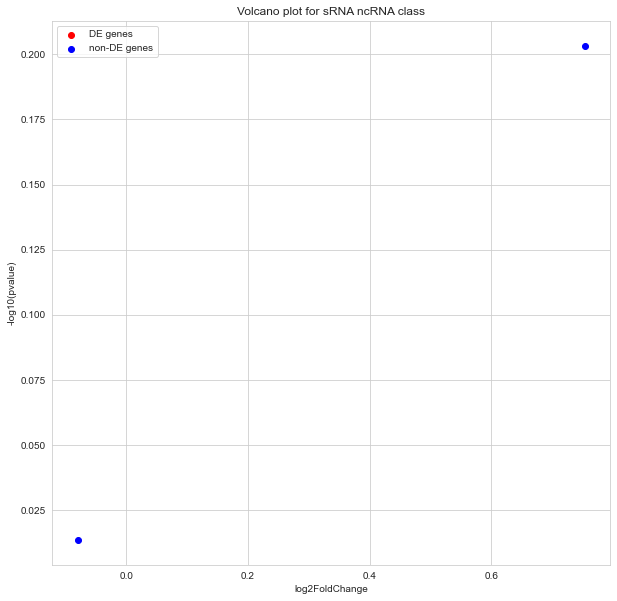

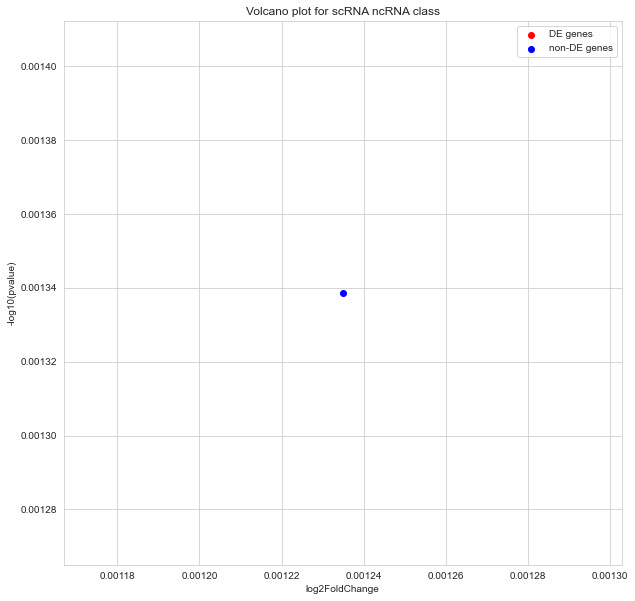

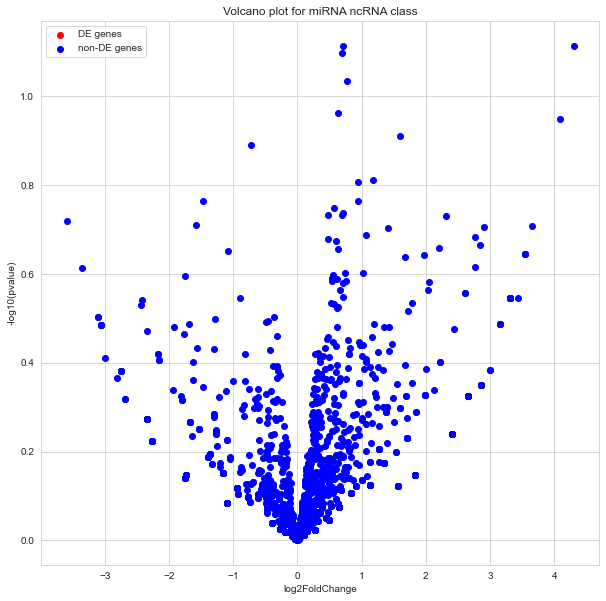

In [463]:
# Volcano plot
def plot_volcano(filtered_df, de_genes_class, ncRNA_class, ax=None):
    if ax is None:
        ax = plt.gca()
    # Plot the differentially expressed genes in red
    ax.scatter(de_genes_class["log2FoldChange"], -np.log10(de_genes_class["pvalue"]), color='red', label='DE genes')

    # Add the id labels for the DE genes
    for i, row in de_genes_class.iterrows():
        ax.annotate(row["id"], (row["log2FoldChange"], -np.log10(row["pvalue"])), fontsize=7)

    # Plot the remaining genes in blue
    non_de_genes_class = filtered_df[~filtered_df.index.isin(de_genes_class.index)]
    ax.scatter(non_de_genes_class["log2FoldChange"], -np.log10(non_de_genes_class["pvalue"]), color='blue', label='non-DE genes')

    # Add the ncRNA label to the plot
    ax.set_xlabel("log2FoldChange")
    ax.set_ylabel("-log10(pvalue)")
    ax.set_title(f"Volcano plot for {ncRNA_class} ncRNA class")
    ax.legend()

# Get the list of unique ncRNA classes from the "id" column
ncRNA_classes = df["id"].apply(lambda x: x.split("_")[1]).unique()

volcano_list = []
for ncRNA_class in ncRNA_classes:
    # Filter the data for the current ncRNA class
    filtered_df = df[df["id"].apply(lambda x: x.split("_")[1] == ncRNA_class)]
    de_genes_class = differentially_expressed[differentially_expressed["id"].apply(lambda x: x.split("_")[1] == ncRNA_class)]
    fig16, ax = plt.subplots(figsize=(10, 10))
    plot_volcano(filtered_df, de_genes_class, ncRNA_class, ax)
    volcano_list.append(fig16)
    

#### heatmap for DE genes

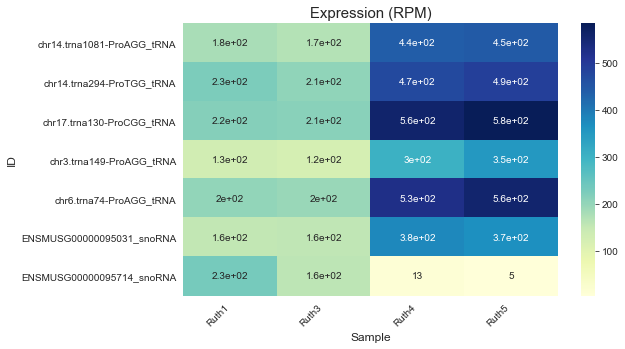

In [464]:
# Subset the differentially expressed genes
diff_exp_gene_values = differentially_expressed.iloc[:,4:]

# Create the heatmap figure
fig17, ax = plt.subplots(figsize=(10,6))
sns.heatmap(diff_exp_gene_values, xticklabels=diff_exp_gene_values.columns, yticklabels=differentially_expressed["id"], cmap="YlGnBu", annot=True, annot_kws={"size": 10}, ax=ax)

# Add labels and title
plt.xlabel("Sample", fontsize=12)
plt.ylabel("ID", fontsize=12)
plt.title("Expression (RPM)", fontsize=15)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.yticks(fontsize=10)

# Adjust the margins to show all the IDs
plt.subplots_adjust(left=0.25, bottom=0.25)

# # Show the plot
# plt.show()


### Export figs as combined PDF

In [465]:
# create a list of the figures to be saved
figures = [fig1, fig2, fig3, fig4] + venn_figs + [fig6, fig7, fig8, fig9, fig10, fig11, fig12, fig13, fig14, fig15] + volcano_list + [fig17]

# create a PDF file using PdfPages
with PdfPages('sncRNA_profiling.pdf') as pdf:
    for fig in figures:
        pdf.savefig(fig)


### Export log2fc values and gene sequences

#### log2fc values for top candidates

In [466]:
differentially_expressed


,id,log2FoldChange,pvalue,padj,Ruth1,Ruth3,Ruth4,Ruth5
201,chr14.trna1081-ProAGG_tRNA,1.343006,4.964050e-05,1.008943e-02,180.557161,169.657010,441.222046,445.995814
205,chr14.trna294-ProTGG_tRNA,1.168520,3.512348e-04,4.079341e-02,225.335337,206.180395,474.621324,493.871071
223,chr17.trna130-ProCGG_tRNA,1.416878,1.145938e-05,3.105491e-03,216.668593,212.071263,559.877377,584.582084
271,chr3.trna149-ProAGG_tRNA,1.361258,8.906250e-05,1.448156e-02,131.445613,124.297324,304.988147,351.505175
362,chr6.trna74-ProAGG_tRNA,1.443893,9.040833e-06,3.105491e-03,203.668477,195.576831,527.357027,558.124705
3501,ENSMUSG00000095031_snoRNA,1.251835,1.980745e-04,2.683909e-02,156.001387,157.875274,379.697059,367.883553
3576,ENSMUSG00000095714_snoRNA,-4.360484,5.755008e-16,4.678822e-13,232.557623,160.820708,13.183926,5.039501


In [467]:
# save to csv 
differentially_expressed.to_csv('de_genes.csv', index=False)

In [468]:
differentially_expressed

,id,log2FoldChange,pvalue,padj,Ruth1,Ruth3,Ruth4,Ruth5
201,chr14.trna1081-ProAGG_tRNA,1.343006,4.964050e-05,1.008943e-02,180.557161,169.657010,441.222046,445.995814
205,chr14.trna294-ProTGG_tRNA,1.168520,3.512348e-04,4.079341e-02,225.335337,206.180395,474.621324,493.871071
223,chr17.trna130-ProCGG_tRNA,1.416878,1.145938e-05,3.105491e-03,216.668593,212.071263,559.877377,584.582084
271,chr3.trna149-ProAGG_tRNA,1.361258,8.906250e-05,1.448156e-02,131.445613,124.297324,304.988147,351.505175
362,chr6.trna74-ProAGG_tRNA,1.443893,9.040833e-06,3.105491e-03,203.668477,195.576831,527.357027,558.124705
3501,ENSMUSG00000095031_snoRNA,1.251835,1.980745e-04,2.683909e-02,156.001387,157.875274,379.697059,367.883553
3576,ENSMUSG00000095714_snoRNA,-4.360484,5.755008e-16,4.678822e-13,232.557623,160.820708,13.183926,5.039501


#### ncRNA sequence for top candidates

In [469]:
# extract the 'id' column as a list
ids = differentially_expressed['id'].str.split('_').str[0].tolist()

# initialize an empty dictionary to store the sequences
sequences = {}

# initialize an empty string to store the current sequence
sequence = ''

# initialize a flag to keep track of header lines
header_line = True

for id in ids:
    
    # iterate over the lines in the fasta file
    for line in lines:
        # if the line starts with a '>', it is a header line
        if line.startswith('>'):
            # if it's not the first header line
            if not header_line:
                # check if the header is in the 'ids' list
                if id in header:
                    # store the sequence in the dictionary
                    sequences[header] = sequence
            # remove the '>' symbol and split the header on spaces
            header = line[1:].strip().split()[0]
            # reset the sequence
            sequence = ''
            # update the header line flag
            header_line = True
        # if the line does not start with a '>', it is a sequence line
        else:
            # add the line to the current sequence
            sequence += line.strip()
            # update the header line flag
            header_line = False

# # store the final sequence in the dictionary
sequences[header] = sequence

# open the output file for writing
with open('top_candidates.fa', 'w') as outfile:
    for id in ids:
        for seq in sequences:
            if id in seq:
                # write the sequences for each id to the output file
                print(f">{seq}\n{sequences[seq]}\n")
                outfile.write(f">{seq}\n{sequences[seq]}\n")

print("Sequences saved to top_candidates.fa")
print("Analysis completed.. Check summary PDF, candidate fasta sequences, and de_genes.csv")


>chr14.trna1081-ProAGG
ACAGGGTGACTGTGAGCCTTGAGGCGAAAATAGAAACCAGGATACCCATCGGCTCGTTGGTCTAGGGGTATGATTCTCGCTTAGGGTGCGAGAGGTCCCGGGTTCAAATCCCGGACGAGCCCTACTTTTGAACTTCTGCTTGGCGAAAAAAATTAAAATTCGGGAAACTAT

>chr14.trna294-ProTGG
CTGCTGTGTTAAAACATGCTAGATTGATGAGCAAGCTGAGCTACCACATGGCTCGTTGGTCTAGGGGTATGATTCTCGCTTTGGGTGCGAGAGGTCCCGGGTTCAAATCCCGGACGAGCCCTGTACTTTTTACATCGTTCTTTTTTAGTAACTGATAGACAAAATGTTCAC

>chr17.trna130-ProCGG
GGGAATGAATACAAGCATTTAAGGAAATGTAGGGAAGTAGCAGTTGTGTGGCTCGTTGGTCTAGGGGTATGATTCTCGCTTCGGGTGCGAGAGGTCCCGGGTTCAAATCCCGGACGAGCCCTGAATGGGGTCCAGTTTCCCAGTGTTTTTATTTCCGTTATTTTTAGAATT

>chr3.trna149-ProAGG
CCAAGACGCCTCAACGGTCATAAAGTGAATCAGAGAGAGTGCCTTACGTGGCTCGTTGGTCTAGGGGTATGATTCTCGCTTAGGGTGCGAGAGGTCCCGGGTTCAAATCCCGGACGAGCCCAATTTTATCTCCCATACAACGTAAACCTGACCTCAGTTGTATTCCGGAGA

>chr6.trna74-ProAGG
GTTGATGATGTGGTAGAGAGGATACATCTGGCCAGGAGTAACCGCCAGTGGCTCGTTGGTCTAGGGGTATGATTCTCGCTTAGGGTGCGAGAGGTCCCGGGTTCAAATCCCGGACGAGCCCTGCTTATCATTTTTTGCTCCCCCTTGGCCAACTTCCACATGCACAGCCTG

>ENSMUSG00000095031_snoRNA


In [471]:
! jupyter nbconvert --to script sncRNA_profiling.ipynb

[NbConvertApp] Converting notebook sncRNA_profiling.ipynb to script
[NbConvertApp] Writing 19504 bytes to sncRNA_profiling.py
